In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import math
import random
import matplotlib.pyplot as plt

Source information for modelling 
https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology

Current version:
* Simulate waves of infection assuming the transmission rate varies periodically
 * Randomly introduce infections
* Adds noise to infection and recovery processes

In [2]:
random.seed(1)

In [3]:
# random tools
# random.randint(a,b) -> a<=x<=b int
# random.random()     -> 0<=x<1  float
# random.uniform(a,b) -> a<=x<b  float
# random.triangular(low,high,mode)
# random.gauss(mu,sigma)
# random.expovariate(lambd) # mean -> 1/lambd



Possible parameters to vary (full list may not be independent, need to select):
* $\beta$ = contacts per person per time
* $\gamma$ = removal rate

The differential equations for the stable population version are:

\begin{equation}
S'(t) = -\frac{\beta I S}{N},
I'(t) = \frac{\beta I S}{N} - \gamma I
R'(t) = \gamma I
\end{equation}

In [4]:
# note: may eventually want to make beta change over time
class MCEvent:
    Npop=0
    Nsteps=0
    # time series of Sus, Inf, Rem
    Sus_arr=0
    Inf_arr=0
    Rem_arr=0
    # parameters
    beta=0
    gamma=0
    def __init__(self,Npop,Nsteps):
        self.Npop=Npop
        self.Nsteps=Nsteps
        self.Sus_arr = np.zeros(Nsteps)
        self.Inf_arr = np.zeros(Nsteps)
        self.Rem_arr = np.zeros(Nsteps)
    def Update(self,step,Sus,Inf,Rem):
        self.Sus_arr[step]=Sus
        self.Inf_arr[step]=Inf
        self.Rem_arr[step]=Rem

In [5]:
Event_List=[]
Npop=100000
num_events=10
num_steps=500
# Can define here hyperparameters setting the random variation of the parameters

In [6]:
debug=False
noise_sigma=5

# avoid prevent overflow of variable x
def rein_in(x,xmin,xmax):
    if (x < xmin):
        return xmin
    if (x > xmax):
        return xmax
    return x

def RunStep_Stochastic(Npop,Sus,Inf,Rem,beta,gamma,intro_rate):
    # stochastic version
    
    # one-sided gaussian noise
    #noise_val_1 = max(0,random.gauss(0,noise_sigma))
    #noise_val_2 = max(0,random.gauss(0,noise_sigma))
    #infection_change = beta * Inf * Sus / Npop + noise_val_1
    #recovery_change = gamma * Inf + noise_val_2
    
    # two-sided gaussian noise
    noise_val_1 = random.gauss(0,noise_sigma)
    noise_val_2 = random.gauss(0,noise_sigma)
    infection_change = beta * Inf * Sus / Npop + noise_val_1
    recovery_change = gamma * Inf + noise_val_2
    
    # prevent noise from making these 
    infection_change = max(0,round(infection_change))
    recovery_change = max(0,round(recovery_change))

    # poisson noise version

    
    #
    newSus=Sus - infection_change
    newInf=Inf + infection_change - recovery_change 
    newRem=Rem + recovery_change

    # Edge cases
    newSus=rein_in(newSus,0,Npop)
    newInf=rein_in(newInf,0,Npop)
    newRem=rein_in(newRem,0,Npop)
    
    if (random.random() < intro_rate):
        # introduce an infection by switching a sus to an inf
        if (newSus > 1): # make sure a sus is available
            newSus -= 1
            newInf += 1
    if (debug):
        print("Run Step:")
        print(f"    Sus: {Sus} -> {newSus}")
        print(f"    Inf: {Inf} -> {newInf}")
        print(f"    Rem: {Rem} -> {newRem}")
    return newSus, newInf, newRem

def RunStep_Analytic(Npop,Sus,Inf,Rem,beta,gamma):
    # analytic version
    newSus=Sus - beta * Inf * Sus / Npop
    newInf=Inf + beta * Inf * Sus / Npop - gamma * Inf 
    newRem=Rem + gamma * Inf
    if (debug):
        print("Run Step:")
        print(f"    Sus: {Sus} -> {newSus}")
        print(f"    Inf: {Inf} -> {newInf}")
        print(f"    Rem: {Rem} -> {newRem}")
    return newSus, newInf, newRem

In [7]:
# Main Event Loop


Event_List=[]
Beta_array_list=[]
for i in range(num_events):
    Sus=Npop
    Inf=0
    Rem=0
    beta_constant=0.5
    beta_period=52. # period unit for beta
    # may want to use some calendar features in the future
    beta_v1=-0.4
    beta_v2=0.1
    beta_w1=0
    beta_w2=0
    gamma=0.7
    intro_rate=0.4 #chance to reintroduce disease
    MCEv = MCEvent(Npop,num_steps)
    Beta_array=np.zeros(num_steps)
    for j in range(num_steps):
        beta=0.8
        beta=beta_constant * (1 + 
                              2 * beta_v1*math.cos(2*math.pi*j/beta_period) +
                              2 * beta_w1*math.sin(2*math.pi*j/beta_period) +
                              2 * beta_v2*math.cos(2*math.pi*2*j/beta_period) +
                              2 * beta_w2*math.sin(2*math.pi*2*j/beta_period)                          
                             )
        Beta_array[j]=beta
        Sus,Inf,Rem = RunStep_Stochastic(Npop,Sus,Inf,Rem,beta,gamma,intro_rate)
        #Sus,Inf,Rem = RunStep_Analytic(Npop,Sus,Inf,Rem,beta,gamma)
        MCEv.Update(j,Sus,Inf,Rem)
    Event_List.append(MCEv)
    Beta_array_list.append(Beta_array)
    print(f'  finished event {i}')


  finished event 0
  finished event 1
  finished event 2
  finished event 3
  finished event 4
  finished event 5
  finished event 6
  finished event 7
  finished event 8
  finished event 9


In [8]:
def DrawBetaArray(arr,ax):
    time_axis=np.arange(0,arr.size,1)
    ax.plot(time_axis,arr)
    plt.xlabel('Time Step')
    
def DrawEvent(evt,ax):
    time_axis=np.arange(0,evt.Nsteps,1)
    ax.plot(time_axis,evt.Sus_arr,color='blue',alpha=0.5)
    ax.plot(time_axis,evt.Inf_arr,color='red')
    ax.plot(time_axis,evt.Rem_arr,color='green',alpha=0.5)
    plt.xlabel('Time Step')
    ax.legend(['Susceptibile','Infectious','Recovered'])
def DrawEvent_Inf(evt,ax):
    time_axis=np.arange(0,evt.Nsteps,1)
    ax.plot(time_axis,evt.Inf_arr,color='red')
    plt.xlabel('Time Step')
    ax.legend(['Infectious'])

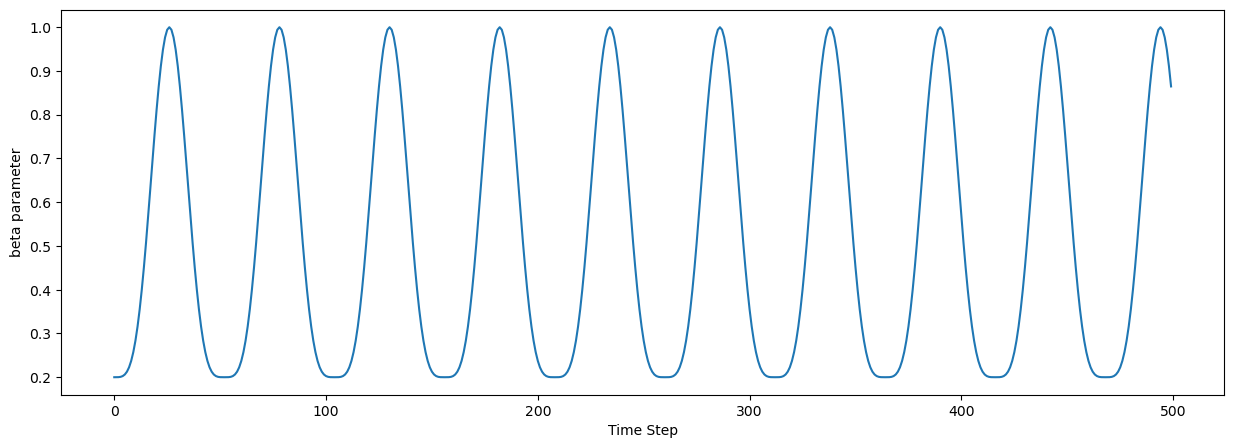

In [9]:
figure, ax1 = plt.subplots(1,1,figsize=(15,5))
DrawBetaArray(Beta_array_list[0],ax1)
plt.ylabel('beta parameter')
plt.savefig('beta_vs_time.png')

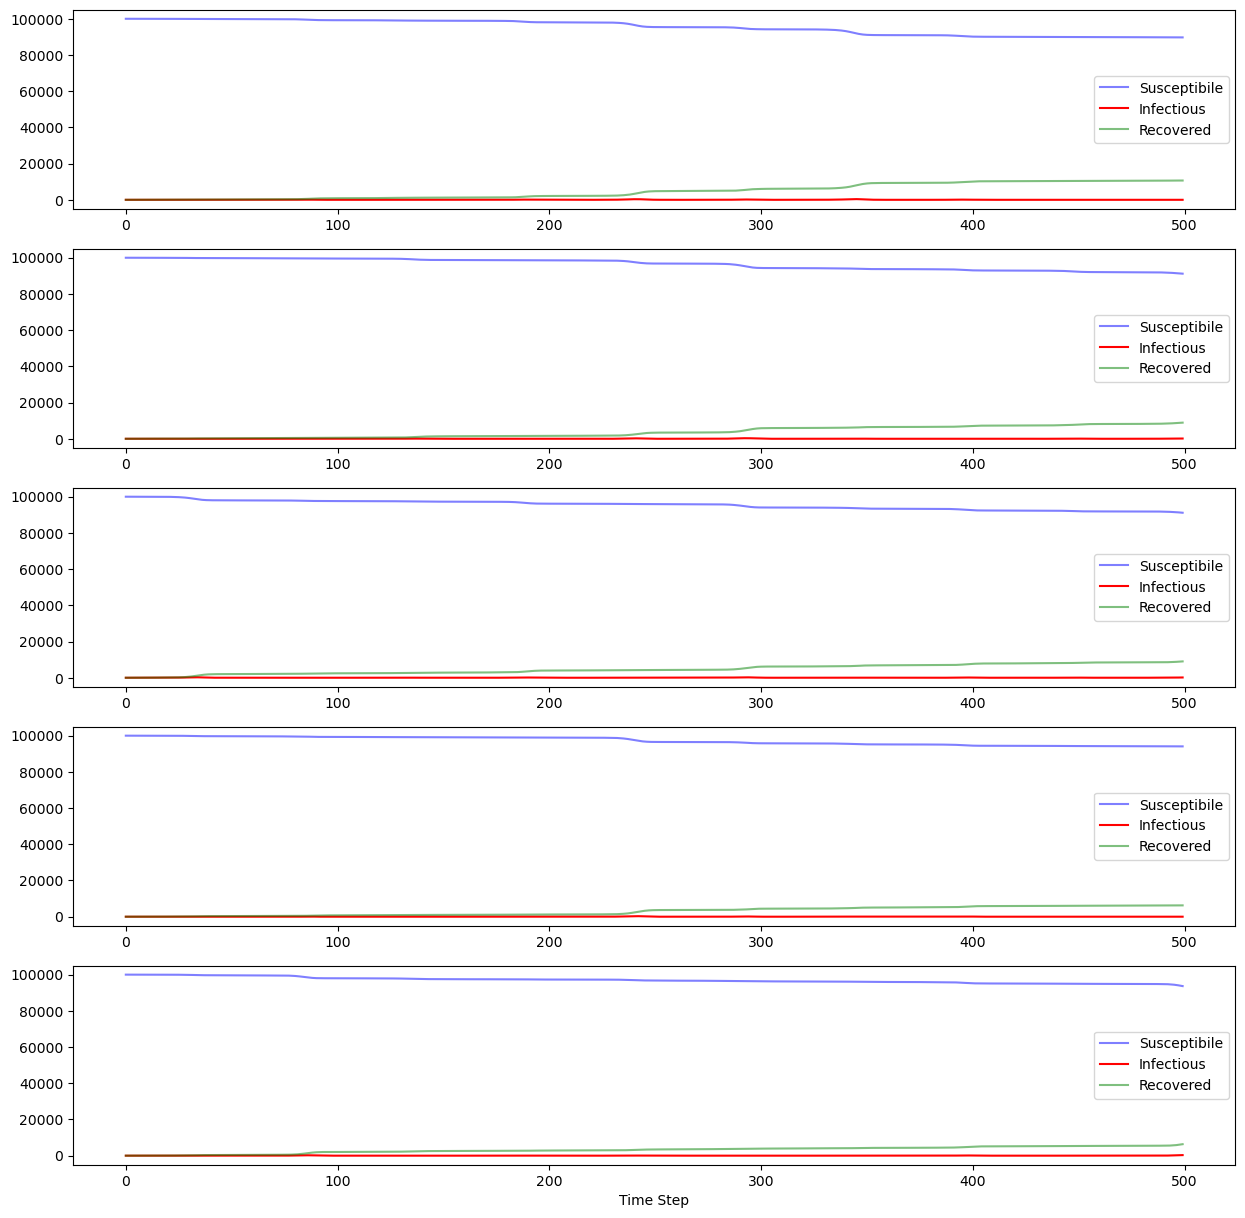

In [10]:
figure, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1,figsize=(15,15))
DrawEvent(Event_List[0],ax1)
DrawEvent(Event_List[1],ax2)
DrawEvent(Event_List[2],ax3)
DrawEvent(Event_List[3],ax4)
DrawEvent(Event_List[4],ax5)

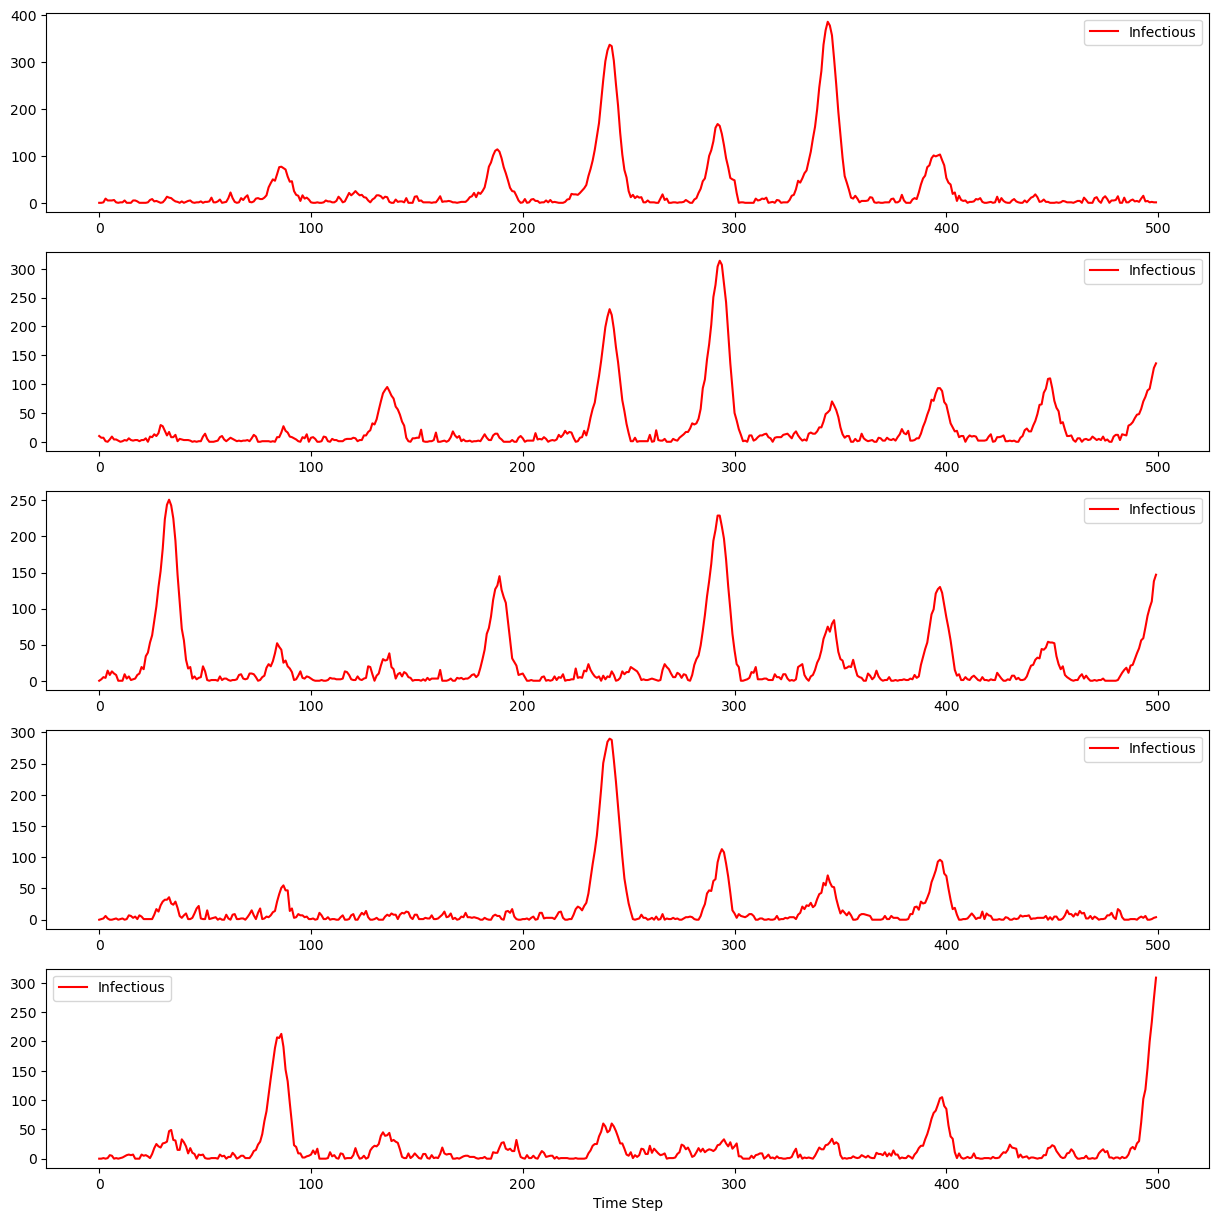

In [11]:
figure, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1,figsize=(15,15))
DrawEvent_Inf(Event_List[0],ax1)
DrawEvent_Inf(Event_List[1],ax2)
DrawEvent_Inf(Event_List[2],ax3)
DrawEvent_Inf(Event_List[3],ax4)
DrawEvent_Inf(Event_List[4],ax5)
plt.savefig('inf_set_1.png')

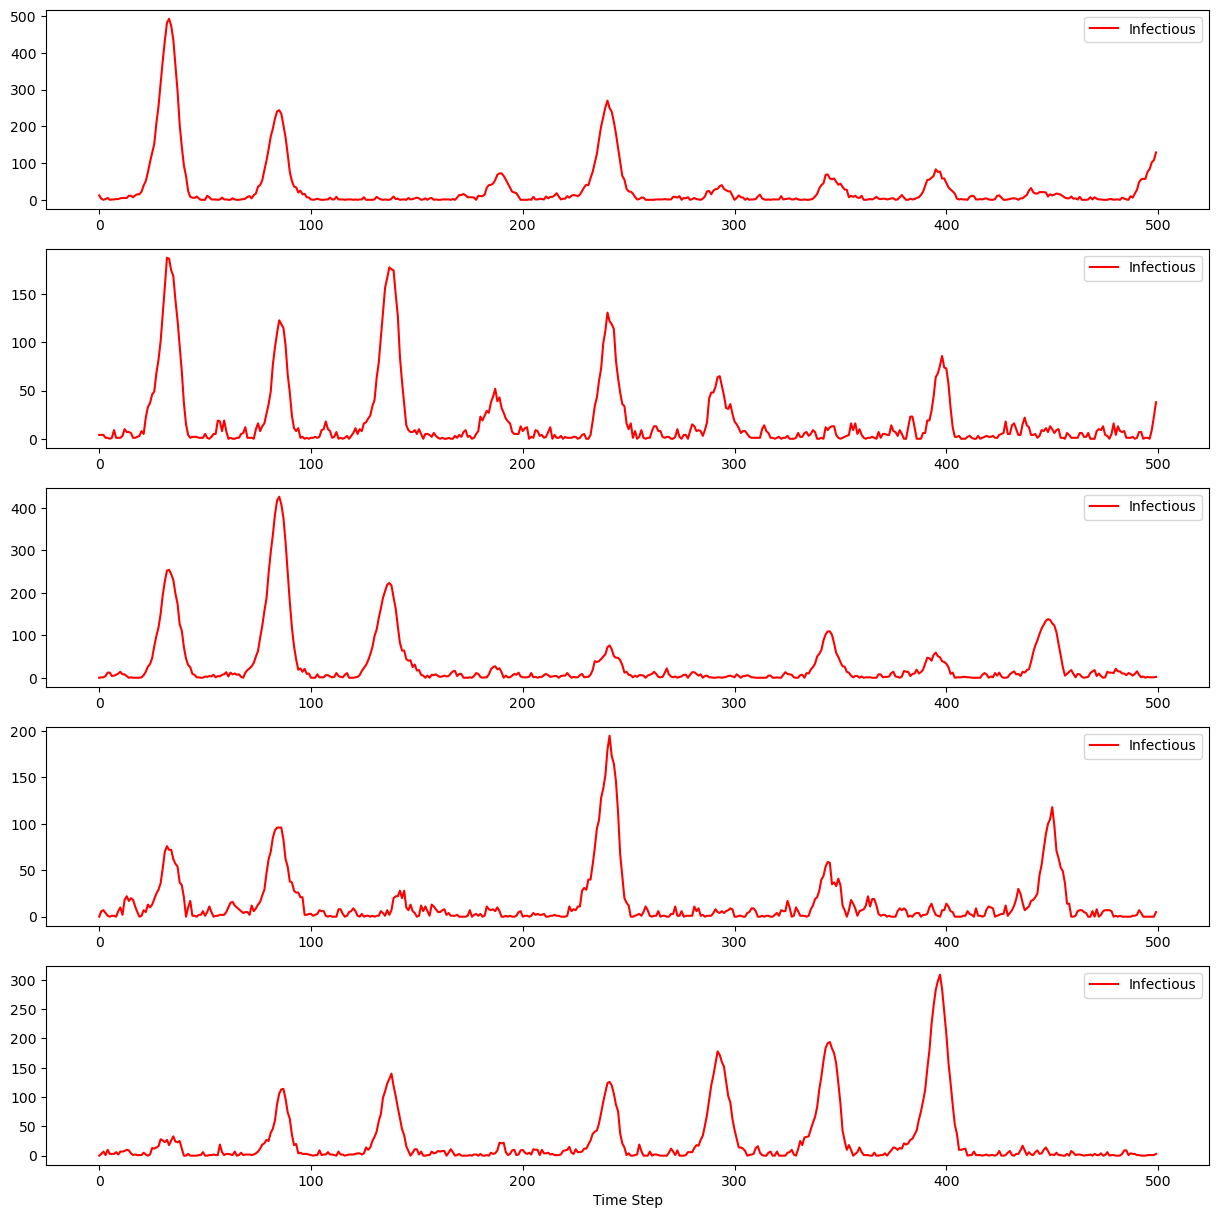

In [12]:
figure, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1,figsize=(15,15))
DrawEvent_Inf(Event_List[5],ax1)
DrawEvent_Inf(Event_List[6],ax2)
DrawEvent_Inf(Event_List[7],ax3)
DrawEvent_Inf(Event_List[8],ax4)
DrawEvent_Inf(Event_List[9],ax5)
plt.savefig('inf_set_2.png')

To add:
* Variable beta (maybe seasonal?) (done)
* Recovery -> susceptible process
 * In the case of dengue fever, immunity is lifelong to the one of three types that causes the infection
  * So, rec -> sus is from population recycling
* Improved noise:
 * Poisson noise for the infection, recovery processes
 * More options than 0 or 1 added infections